<a href="https://colab.research.google.com/github/vitinhx/TAIA/blob/main/Apriori/analysis_market.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Discentes:
Matheus Lima do Couto

Victor Ivan Silva Silveira



---


Fonte: https://github.com/vitinhx/TAIA/tree/f90a0db64c3ffe82422362a583a557bfdf34ddd8/Apriori


---

# Implementação

## Importações das bibliotecas

In [401]:
!pip install mlxtend

In [402]:
!pip install apyori

In [498]:
import numpy as np
import pandas as pd

from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

from apyori import apriori as ap

import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Carregamento dos dados

In [404]:
link_dataset = 'https://raw.githubusercontent.com/vitinhx/TAIA/main/Apriori/datasets/Groceries_dataset.csv'
df = pd.read_csv(link_dataset)

## Pré-processamento

In [405]:
df

,Member_number,Date,itemDescription
0,1808,21-07-2015,tropical fruit
1,2552,05-01-2015,whole milk
2,2300,19-09-2015,pip fruit
3,1187,12-12-2015,other vegetables
4,3037,01-02-2015,whole milk
...,...,...,...
38760,4471,08-10-2014,sliced cheese
38761,2022,23-02-2014,candy
38762,1097,16-04-2014,cake bar
38763,1510,03-12-2014,fruit/vegetable juice


Verificando o nome das colunas

In [406]:
df.columns

Index(['Member_number', 'Date', 'itemDescription'], dtype='object')

Quantidade de linhas e colunas

In [407]:
df.shape

(38765, 3)

Informações gerais do dataframe

In [408]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38765 entries, 0 to 38764
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   Date             38765 non-null  object
 2   itemDescription  38765 non-null  object
dtypes: int64(1), object(2)
memory usage: 908.7+ KB


Verificando a existência de valores ausentes

In [409]:
df.isnull().sum()

Member_number      0
Date               0
itemDescription    0
dtype: int64

In [410]:
df.loc[df['itemDescription']=='NONE', :]

,Member_number,Date,itemDescription


In [411]:
df_apyori = df

Identificação das transações

In [512]:
list_of_transactions = df[['Member_number', 'Date']].drop_duplicates().reset_index(drop=True).reset_index().rename(columns={'index': 'Transaction'})
list_of_transactions

,Transaction,Member_number,Date
0,0,1808,2015-07-21
1,1,2552,2015-05-01
2,2,2300,2015-09-19
3,3,1187,2015-12-12
4,4,3037,2015-01-02
...,...,...,...
14958,14958,1740,2014-11-07
14959,14959,1006,2014-11-07
14960,14960,4993,2014-05-25
14961,14961,1888,2014-02-08


In [ ]:
df = df.merge(list_of_transactions, on=['Member_number', 'Date'], how='left')
df

Reformatação das datas

In [414]:
def split_date_field(df_orig):
    """
    Converts the Date Column into three separate columns
    (YYYY-MM-DD) -> (YYYY, MM, DD)
    """
    df = df_orig.copy()
    date = pd.to_datetime(df['Date'])

    df['Year'] = date.dt.year
    df['Month'] = date.dt.month
    df['Day'] = date.dt.day

    month_map = {
        1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
        5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
        9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
    }
    df['Month'] = df['Month'].map(month_map)

    weekday_map = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
    df['Weekday'] = date.dt.weekday.apply(lambda x: weekday_map[x])

    return df
df_with_dates = split_date_field(df)
df_with_dates.head()

,Member_number,Date,itemDescription,Transaction,Year,Month,Day,Weekday
0,1808,21-07-2015,tropical fruit,0,2015,Jul,21,Tue
1,2552,05-01-2015,whole milk,1,2015,May,1,Fri
2,2300,19-09-2015,pip fruit,2,2015,Sep,19,Sat
3,1187,12-12-2015,other vegetables,3,2015,Dec,12,Sat
4,3037,01-02-2015,whole milk,4,2015,Jan,2,Fri


## Análise exploratória

Itens únicos

In [415]:
df['itemDescription'].nunique()

167

Itens mais vendidos

In [416]:
transaction_count = df.groupby(by='itemDescription')[['Transaction']].count().sort_values(by='Transaction', ascending=False)
transaction_count.head(10)

,Transaction
itemDescription,
whole milk,2502
other vegetables,1898
rolls/buns,1716
soda,1514
yogurt,1334
root vegetables,1071
tropical fruit,1032
bottled water,933
sausage,924


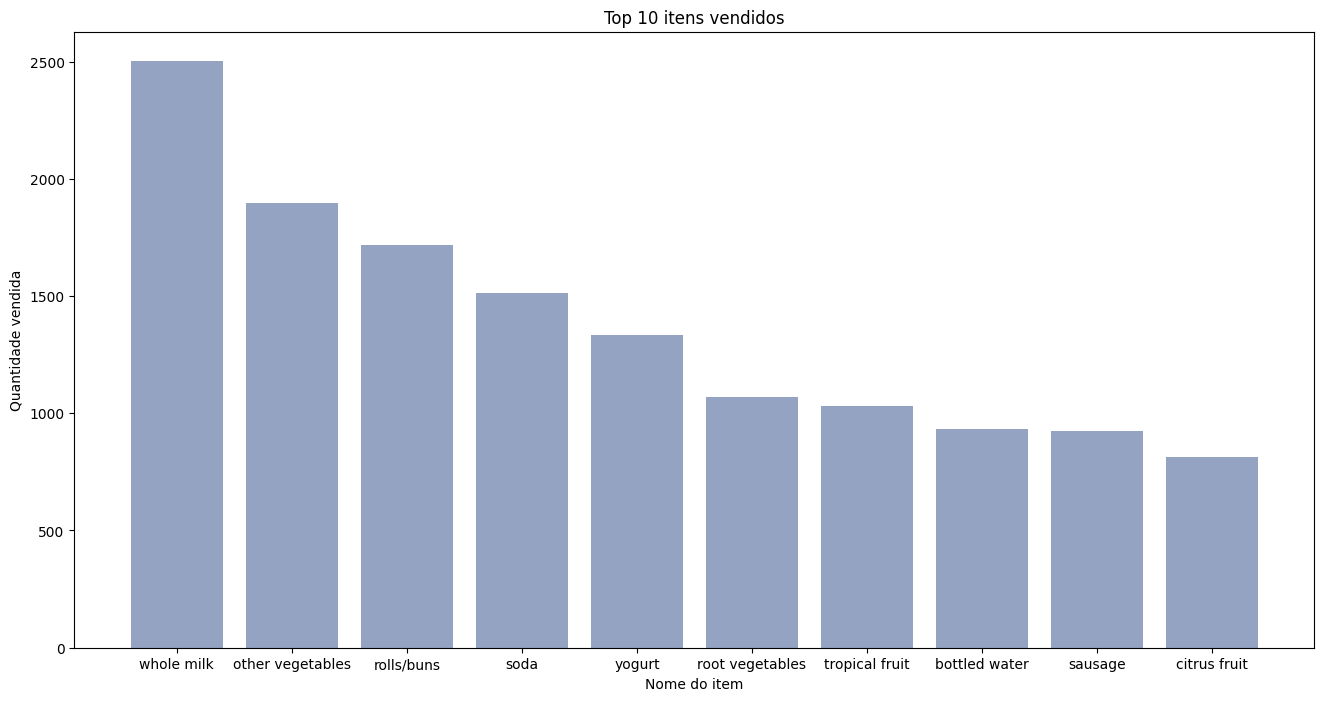

In [508]:
Item_distr = df.groupby(by = "itemDescription").size().reset_index(name='Frequency').sort_values(by = 'Frequency',ascending=False).head(10)


bars = Item_distr["itemDescription"]
height = Item_distr["Frequency"]
x_pos = np.arange(len(bars))


plt.figure(figsize=(16,8))

plt.bar(x_pos, height, color=(0.3, 0.4, 0.6, 0.6))

plt.title("Top 10 itens vendidos")
plt.xlabel("Nome do item")
plt.ylabel("Quantidade vendida")

plt.xticks(x_pos, bars)

plt.show()

Balanço anual de vendas

In [418]:
df_copy = df
df_copy['Date'] = pd.to_datetime(df_copy['Date'])
df_date = df_copy.set_index(['Date'])
df_date.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38765 entries, 2015-07-21 to 2014-12-26
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Member_number    38765 non-null  int64 
 1   itemDescription  38765 non-null  object
 2   Transaction      38765 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ MB


[Text(0.5, 0, 'Mês'), Text(0, 0.5, 'Número de itens vendidos')]

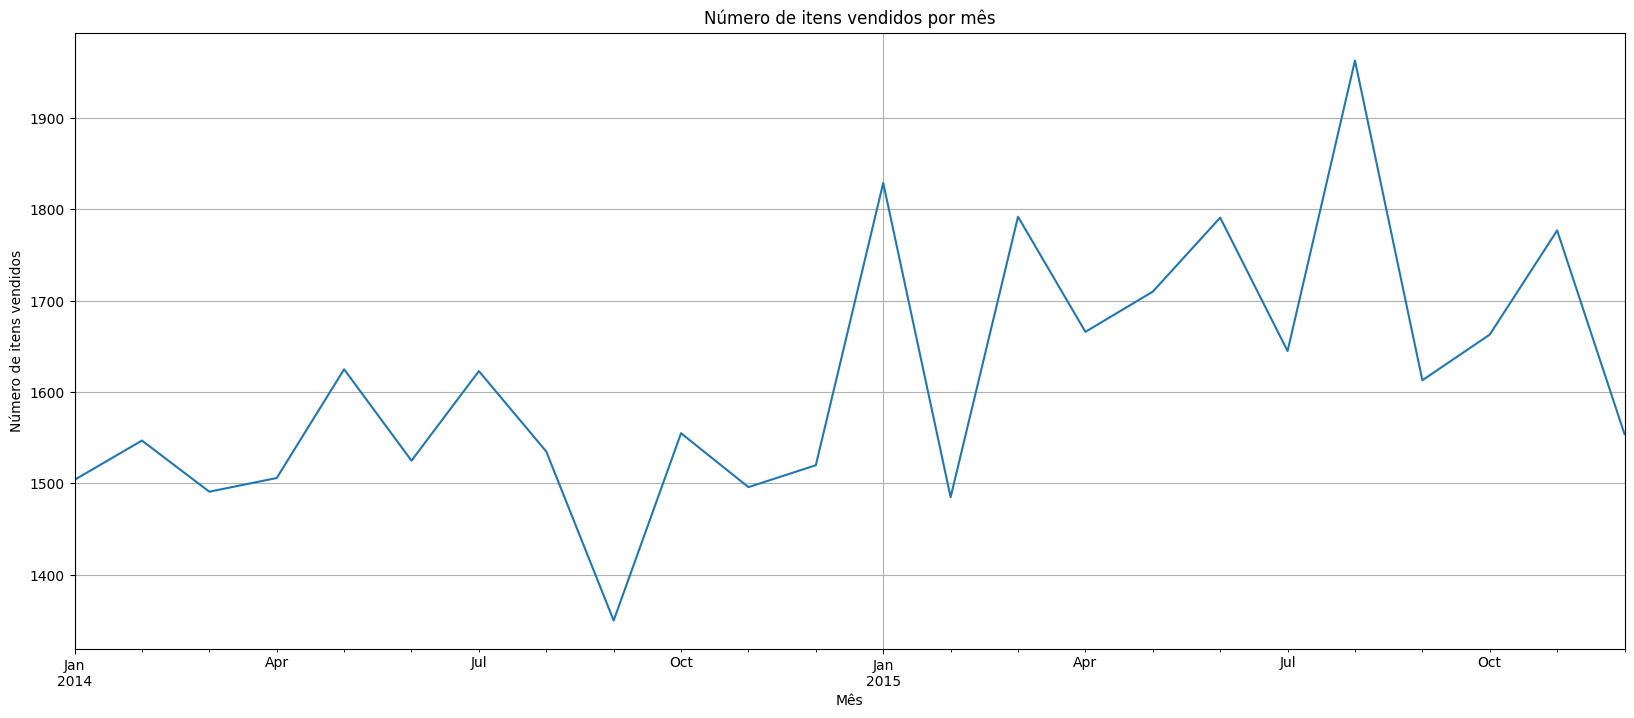

In [509]:
df_date.resample("M")['itemDescription'].count().plot(figsize = (20,8),
                                                      grid = True,
                                                      title = "Número de itens vendidos por mês").set(xlabel = "Mês",
                                                                                                   ylabel = "Número de itens vendidos")

Item mais vendido a cada mês

In [420]:
top_items_by_month = df_with_dates.groupby(['Year', 'Month', 'itemDescription'])['Member_number'].count().reset_index(name='Transaction_Count')
top_items_per_month_year = top_items_by_month.groupby(['Year', 'Month']).apply(lambda x: x.nlargest(1, 'Transaction_Count')).reset_index(drop=True)
top_items_per_month = top_items_by_month.groupby(['Month']).apply(lambda x: x.nlargest(1, 'Transaction_Count')).reset_index(drop=True).drop('Year', axis=1)

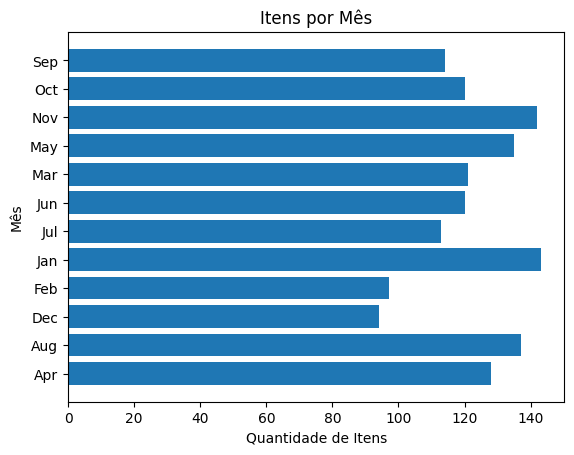

In [421]:
plt.barh(top_items_per_month['Month'], top_items_per_month['Transaction_Count'])

plt.xlabel('Quantidade de Itens')
plt.ylabel('Mês')
plt.title('Itens por Mês')

plt.show()

In [422]:
print(top_items_per_month)

   Month itemDescription  Transaction_Count
0    Apr      whole milk                128
1    Aug      whole milk                137
2    Dec      whole milk                 94
3    Feb      whole milk                 97
4    Jan      whole milk                143
5    Jul      whole milk                113
6    Jun      whole milk                120
7    Mar      whole milk                121
8    May      whole milk                135
9    Nov      whole milk                142
10   Oct      whole milk                120
11   Sep      whole milk                114


## Algoritmo Apriori

### MLxtend

Preparando o dataframe

In [423]:
df['Quantity'] = 1
df.head()

,Member_number,Date,itemDescription,Transaction,Quantity
0,1808,2015-07-21,tropical fruit,0,1
1,2552,2015-05-01,whole milk,1,1
2,2300,2015-09-19,pip fruit,2,1
3,1187,2015-12-12,other vegetables,3,1
4,3037,2015-01-02,whole milk,4,1


In [424]:
basket = df.groupby(['Transaction', 'itemDescription'])['Quantity'].sum().unstack().fillna(0)
basket

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Transaction,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
14959,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14960,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Transformação de flutuante para booleano

In [426]:
# Define a function to encode values into binary (0 or 1)
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1

basket_sets = basket.applymap(encode_units)

In [427]:
basket_sets

itemDescription,Instant food products,UHT-milk,abrasive cleaner,artif. sweetener,baby cosmetics,bags,baking powder,bathroom cleaner,beef,berries,...,turkey,vinegar,waffles,whipped/sour cream,whisky,white bread,white wine,whole milk,yogurt,zwieback
Transaction,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14958,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
14959,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14960,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Encontrando valores de suporte e confiança

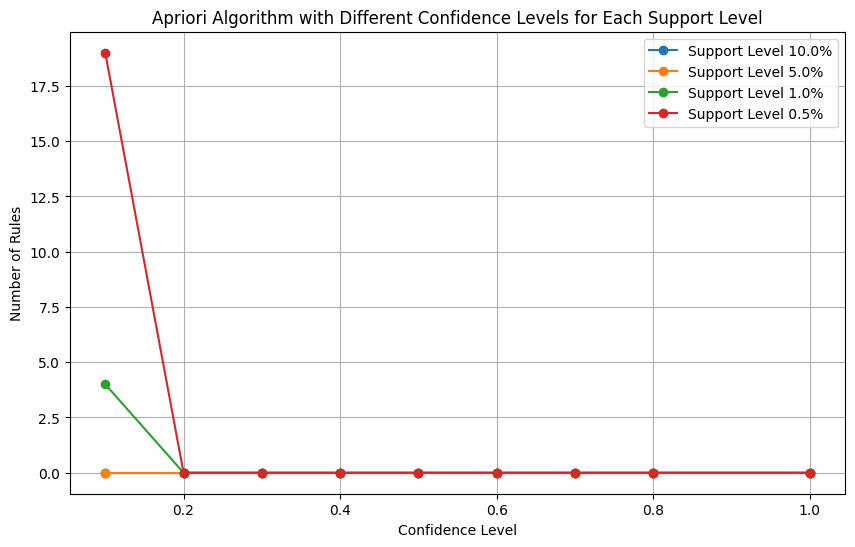

In [428]:
def apriori_confidence_levels(data, support_levels, confidence_levels):
    rule_counts = []

    for support_level in support_levels:
        current_rule_counts = []
        for confidence_level in confidence_levels:
            rules = association_rules(apriori(data, min_support=support_level, use_colnames=True), metric='confidence', min_threshold=confidence_level)
            current_rule_counts.append(len(rules))
        rule_counts.append(current_rule_counts)

    return rule_counts

def plot_confidence_levels(support_levels, confidence_levels, rule_counts):
    plt.figure(figsize=(10, 6))

    for i, support_level in enumerate(support_levels):
        plt.plot(confidence_levels, rule_counts[i], marker='o', label=f'Support Level {support_level*100}%')

    plt.title("Apriori Algorithm with Different Confidence Levels for Each Support Level")
    plt.xlabel('Confidence Level')
    plt.ylabel('Number of Rules')
    plt.legend()
    plt.grid(True)
    plt.show()


support_levels = [0.1, 0.05, 0.01, 0.005]
confidence_levels = [1.0, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

rule_counts = apriori_confidence_levels(basket_sets, support_levels, confidence_levels)
plot_confidence_levels(support_levels, confidence_levels, rule_counts)

Testando com o suporte minimo

In [464]:
# The result is a table that lists the frequent sets and their relative frequency ('support').
frequent_itemsets = apriori(basket_sets, min_support=0.001, use_colnames=True, verbose=1)
frequent_itemsets

Processing 28 combinations | Sampling itemset size 4


,support,itemsets
0,0.004010,(Instant food products)
1,0.021386,(UHT-milk)
2,0.001470,(abrasive cleaner)
3,0.001938,(artif. sweetener)
4,0.008087,(baking powder)
...,...,...
745,0.001136,"(whole milk, rolls/buns, sausage)"
746,0.001002,"(soda, whole milk, rolls/buns)"
747,0.001337,"(yogurt, whole milk, rolls/buns)"
748,0.001069,"(soda, whole milk, sausage)"


In [518]:
rules_sup1_conf50 = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.2)
rules_sup1_conf50

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,"(rolls/buns, sausage)",(whole milk),0.005347,0.157923,0.001136,0.212500,1.345594,0.000292,1.069304,0.258214
1,"(yogurt, sausage)",(whole milk),0.005748,0.157923,0.001470,0.255814,1.619866,0.000563,1.131541,0.384877


### Visualização dos resultados

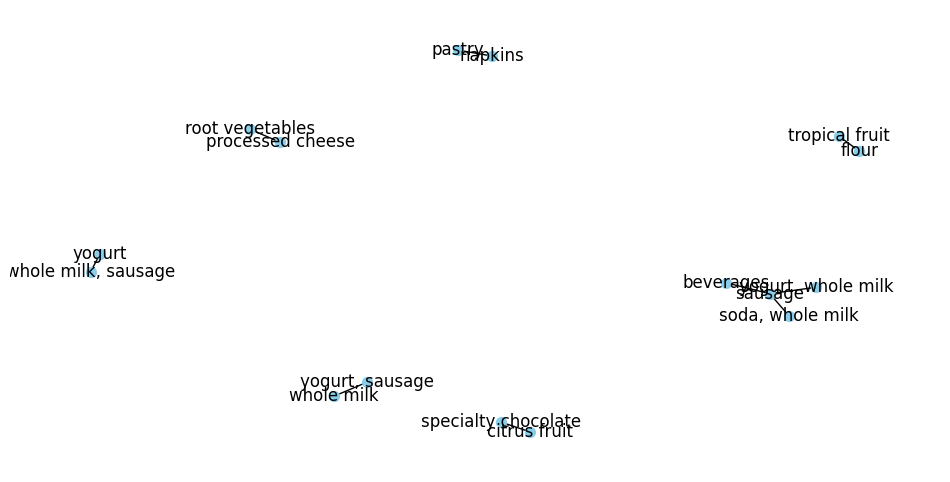

In [495]:
GA = nx.from_pandas_edgelist(rules_sup1_conf50, source='antecedents', target='consequents')

node_labels = {node: ', '.join(map(str, node)) for node in GA.nodes()}
fig, ax = plt.subplots(figsize=(12, 6))
nx.draw(GA, with_labels=True, labels=node_labels, font_size=12, font_color='black', node_size=50, node_color='skyblue', ax=ax)
plt.show()

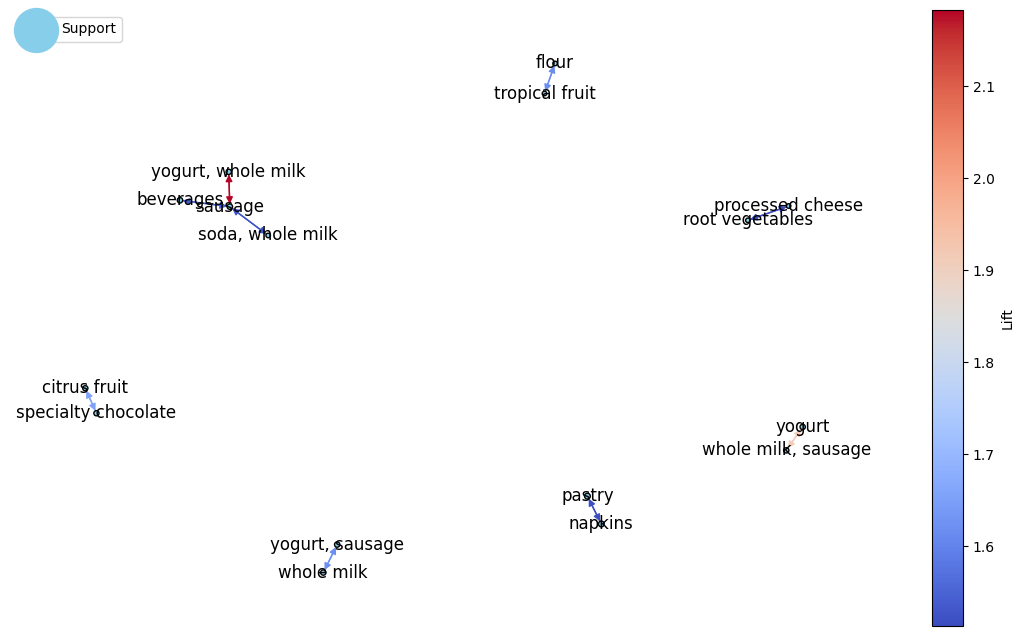

In [496]:
# based on lift
filtered_rules = rules_sup1_conf50[rules_sup1_conf50['lift'] > 1.0]
GA1 = nx.from_pandas_edgelist(filtered_rules, source='antecedents', target='consequents', create_using=nx.DiGraph())
GA = nx.relabel_nodes(GA1, {node: ', '.join(map(str, node)) for node in GA1.nodes()})

# support
node_sizes = [filtered_rules[filtered_rules['antecedents'] == set(node)]['support'].values[0] * 10000
              if len(filtered_rules[filtered_rules['antecedents'] == set(node)]) > 0 else 0 for node in GA1.nodes]
# lift
edge_colors = [filtered_rules[(filtered_rules['antecedents'] == set(edge[0])) & (filtered_rules['consequents'] == set(edge[1]))]['lift'].values[0]
               if len(filtered_rules[(filtered_rules['antecedents'] == set(edge[0])) & (filtered_rules['consequents'] == set(edge[1]))]) > 0 else 0 for edge in GA1.edges]

fig, ax = plt.subplots(figsize=(14, 8))
nx.draw(GA, with_labels=True, font_size=12, font_color='black', node_size=node_sizes, node_color='skyblue',
        edge_color=edge_colors, edge_cmap=plt.cm.coolwarm, ax=ax, width=1, edgecolors='black')
legend_handle = ax.scatter([], [], s=1000, color='skyblue', label='Support')

sm = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.set_label('Lift')

plt.legend(handles=[legend_handle], loc='upper left')
plt.show()

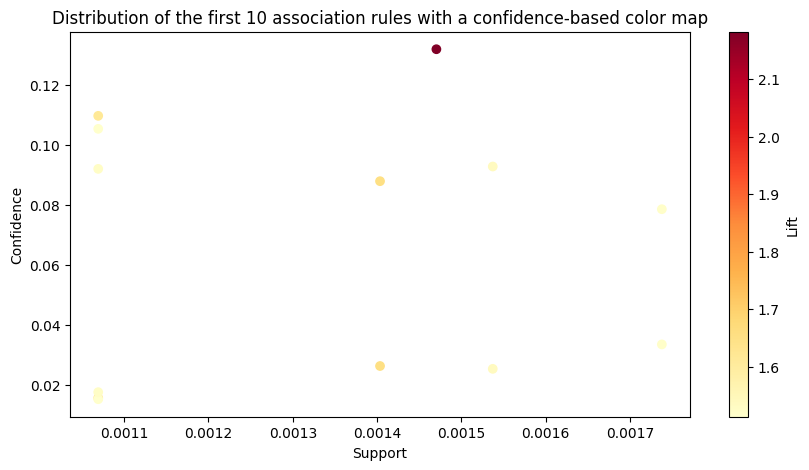

In [497]:
# Visualizing the rules distribution color mapped by confidence
plt.figure(figsize=(10, 5))
plt.scatter(rules_sup1_conf50['support'].head(13), rules_sup1_conf50['confidence'].head(13), c=rules_sup1_conf50['lift'].head(13), cmap='YlOrRd')
plt.title('Distribution of the first 10 association rules with a confidence-based color map')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.colorbar(label = 'Lift')
plt.show()

In [499]:
rules_sup1_conf50

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(beverages),(sausage),0.016574,0.060349,0.001537,0.092742,1.536764,0.000537,1.035704,0.355168
1,(sausage),(beverages),0.060349,0.016574,0.001537,0.025471,1.536764,0.000537,1.009129,0.371714
2,(citrus fruit),(specialty chocolate),0.053131,0.015973,0.001403,0.026415,1.653762,0.000555,1.010726,0.417500
3,(specialty chocolate),(citrus fruit),0.015973,0.053131,0.001403,0.087866,1.653762,0.000555,1.038081,0.401735
4,(tropical fruit),(flour),0.067767,0.009757,0.001069,0.015779,1.617141,0.000408,1.006118,0.409366
5,(flour),(tropical fruit),0.009757,0.067767,0.001069,0.109589,1.617141,0.000408,1.046969,0.385385
6,(napkins),(pastry),0.022121,0.051728,0.001738,0.078550,1.518529,0.000593,1.029109,0.349192
7,(pastry),(napkins),0.051728,0.022121,0.001738,0.033592,1.518529,0.000593,1.011869,0.360095
8,(processed cheese),(root vegetables),0.010158,0.069572,0.001069,0.105263,1.513019,0.000363,1.039891,0.342549
9,(root vegetables),(processed cheese),0.069572,0.010158,0.001069,0.015370,1.513019,0.000363,1.005293,0.364423


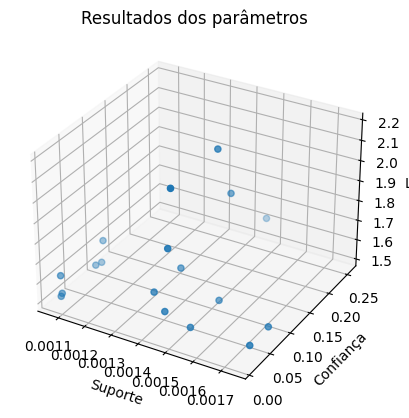

In [502]:
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')

support = rules_sup1_conf50['support']
confidence = rules_sup1_conf50['confidence']
lift = rules_sup1_conf50['lift']

ax.scatter(support, confidence, lift)

ax.set_xlabel('Suporte')
ax.set_ylabel('Confiança')
ax.set_zlabel('Lift')
plt.title('Resultados dos parâmetros')

plt.show()

### Apyori

Preparação de dados

In [431]:
cust_level = df_apyori[["Member_number", "itemDescription"]].sort_values(by = "Member_number", ascending = False) ## Selecting only required variables for modelling
cust_level['itemDescription'] = cust_level['itemDescription'].str.strip() # Removing white spaces if any
cust_level

,Member_number,itemDescription
3578,5000,soda
34885,5000,semi-finished bread
11728,5000,fruit/vegetable juice
9340,5000,bottled beer
19727,5000,root vegetables
...,...,...
13331,1000,whole milk
17778,1000,pickled vegetables
6388,1000,sausage
20992,1000,semi-finished bread


Criando lista de transação

In [432]:
transactions = [a[1]['itemDescription'].tolist() for a in list(cust_level.groupby(['Member_number']))] ## Combing all the items in list format for each cutomer

Treinamento do modelo

In [469]:
rules = ap(transactions = transactions, min_support = 0.001, min_confidence = 0.05, min_lift = 1.5, min_length = 2, max_length = 2) ## Model Creation

Resultados

In [ ]:
results = list(rules)
results

In [471]:
def inspect(results):
    lhs         = [tuple(result[2][0][0])[0] for result in results]
    rhs         = [tuple(result[2][0][1])[0] for result in results]
    supports    = [result[1] for result in results]
    confidences = [result[2][0][2] for result in results]
    lifts       = [result[2][0][3] for result in results]
    return list(zip(lhs, rhs, supports, confidences, lifts))
resultsinDataFrame = pd.DataFrame(inspect(results), columns = ['Antecedents', 'Consequents', 'Support', 'Confidence', 'Lift'])

In [472]:
resultsinDataFrame.nlargest(n=10, columns="Lift") ## Showing best possible scenarios

,Antecedents,Consequents,Support,Confidence,Lift
933,jam,rice,0.001026,0.117647,9.358944
353,rum,canned vegetables,0.001026,0.125000,6.090625
1064,ready soups,oil,0.001283,0.333333,5.987711
397,ready soups,chewing gum,0.001026,0.266667,5.973946
372,tea,cat food,0.001796,0.259259,5.909898
15,Instant food products,soups,0.001026,0.066667,5.413889
584,decalcifier,dessert,0.001026,0.444444,5.140785
340,canned fruit,soft cheese,0.001026,0.190476,5.050858
874,tea,herbs,0.001283,0.185185,4.717986
593,dental care,seasonal products,0.001026,0.121212,4.678068


# Perguntas da tarefa



*   pt1: O que acontece quando diminuímos o nível de suporte? Por que?
*   pt2: O que acontece quando aumentamos o nível de confiança? Por que?
*   pt3: Como interpretar os resultados em termos de lift e qual seria um valor "bom" para o lift em um contexto específico?
*   pt4: Usando o conjunto de dados anterior, execute o algoritmo Apriori com um nível de suporte de 5% e um nível de confiança de 10%. As regras são interessantes? Por que?
*   pt5: Execute também o algoritmo Apriori com um nível de suporte de 0.5% e um nível de confiança de 60%. As regras são interessantes? Por que?



# Referências

*   https://github.com/GabrieleAraujo/database-data-mining/tree/main
*   https://www.kaggle.com/datasets/heeraldedhia/groceries-dataset/code?datasetId=877335&sortBy=voteCount
*   OLIVEIRA, Joana Raquel Carias de. Data Mining na procura de nova informação: Market Basket Analysis aplicado a um dataset público. 2019. Tese de Doutorado.
*   SOARES, Douglas de Oliveira. Marketing digital e ciência de dados: recomendações de produtos. 2022.
*   https://youtu.be/Mq5HPAFXrOI?si=GXzqkB6MCtUnYeih
*   https://youtu.be/YGEYty0xYc0?si=oKWHBdxGtRbLApW5
